In [1]:
import csv
import numpy as np
import pandas as pd
from datetime import date
from datetime import datetime
from requests import get
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot as plt
%matplotlib inline

Using Theano backend.
Using gpu device 0: GeForce GTX 560M (CNMeM is enabled with initial size: 50.0% of memory, cuDNN not available)


In [2]:
# I DON'T LIKE THE RESULTS OF THE SENTIMENT ANALYSIS SO I WON'T USE IT

In [3]:
# Download CSV from google finance

COMPANY = 'AMZN'

url = 'http://www.google.com/finance/historical?q=NASDAQ%3A'+COMPANY+'&output=csv'

r = get(url, stream=True)

In [4]:
# Put data in dataframe

splitted = r.text.split('\n')
double_splitted = [row.split(',') for row in splitted]
df = pd.DataFrame(double_splitted)
df.columns = double_splitted[0]
df = df.ix[1:]
df = df[:-1]

In [5]:
# CONVERT DATE TO NUMBER
# ANOTHER OPTION IS TO USE LIBREOFFICE CALC DATEVALUE FUNCTION

last_date = datetime.strptime(df['Date'].ix[len(df)], '%d-%b-%y').date()
dates = [(datetime.strptime(d,'%d-%b-%y').date() - last_date).days for d in df['Date']]

In [6]:
df['Date'] = dates

In [7]:
# fix random seed for reproducibility
np.random.seed(7)

In [63]:
# load dataset 
dataset = df[['Date','Open']].values

In [9]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [10]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 1]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 1])
    return np.array(dataX), np.array(dataY)

# reshape dataset
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [24]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(50, input_dim=look_back, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=1000, batch_size=2, verbose=2)

Epoch 1/1000
0s - loss: 20399.1881
Epoch 2/1000
0s - loss: 155.5021
Epoch 3/1000
0s - loss: 141.8290
Epoch 4/1000
0s - loss: 143.4373
Epoch 5/1000
0s - loss: 133.6709
Epoch 6/1000
0s - loss: 153.7686
Epoch 7/1000
0s - loss: 239.9590
Epoch 8/1000
0s - loss: 161.5773
Epoch 9/1000
0s - loss: 160.4554
Epoch 10/1000
0s - loss: 146.7946
Epoch 11/1000
0s - loss: 164.5315
Epoch 12/1000
0s - loss: 169.0940
Epoch 13/1000
0s - loss: 148.4073
Epoch 14/1000
0s - loss: 161.8800
Epoch 15/1000
0s - loss: 161.2776
Epoch 16/1000
0s - loss: 155.7616
Epoch 17/1000
0s - loss: 167.1081
Epoch 18/1000
0s - loss: 160.9263
Epoch 19/1000
0s - loss: 211.5482
Epoch 20/1000
0s - loss: 222.5275
Epoch 21/1000
0s - loss: 187.4661
Epoch 22/1000
0s - loss: 156.6469
Epoch 23/1000
0s - loss: 205.1103
Epoch 24/1000
0s - loss: 175.3414
Epoch 25/1000
0s - loss: 142.7717
Epoch 26/1000
0s - loss: 142.5842
Epoch 27/1000
0s - loss: 161.1833
Epoch 28/1000
0s - loss: 205.0638
Epoch 29/1000
0s - loss: 145.4905
Epoch 30/1000
0s - lo

In [25]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

Train Score: 152.72 MSE (12.36 RMSE)
Test Score: 193.88 MSE (13.92 RMSE)


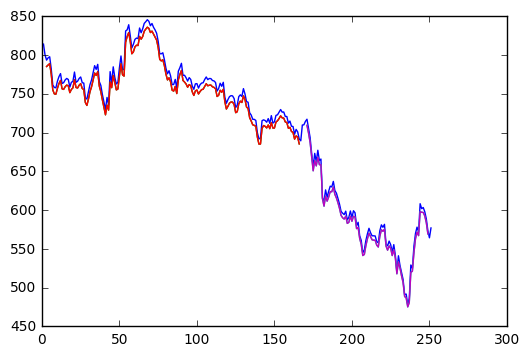

In [26]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(df['Open'])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [27]:
# LSTM
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [68]:
# normalize the dataset (required for faster convergence)
scaler = MinMaxScaler(feature_range=(0, 1))
norm_dataset = scaler.fit_transform(dataset)

/home/fd/Dev/siraj/dschallenges/.env/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [69]:
# split into train and test sets
train, test = norm_dataset[0:train_size,:], norm_dataset[train_size:len(norm_dataset),:]
print(len(train), len(test))

168 83


In [78]:
# reshape dataset
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [79]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [80]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_dim=look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

Epoch 1/100
1s - loss: 0.1186
Epoch 2/100
0s - loss: 0.0032
Epoch 3/100
0s - loss: 0.0029
Epoch 4/100
0s - loss: 0.0027
Epoch 5/100
0s - loss: 0.0025
Epoch 6/100
0s - loss: 0.0022
Epoch 7/100
0s - loss: 0.0020
Epoch 8/100
0s - loss: 0.0018
Epoch 9/100
0s - loss: 0.0016
Epoch 10/100
0s - loss: 0.0015
Epoch 11/100
0s - loss: 0.0013
Epoch 12/100
0s - loss: 0.0012
Epoch 13/100
0s - loss: 0.0011
Epoch 14/100
0s - loss: 9.7944e-04
Epoch 15/100
0s - loss: 9.8167e-04
Epoch 16/100
0s - loss: 9.2862e-04
Epoch 17/100
0s - loss: 9.6016e-04
Epoch 18/100
0s - loss: 9.3743e-04
Epoch 19/100
0s - loss: 9.0912e-04
Epoch 20/100
0s - loss: 8.4149e-04
Epoch 21/100
1s - loss: 8.7762e-04
Epoch 22/100
0s - loss: 8.9802e-04
Epoch 23/100
0s - loss: 8.4725e-04
Epoch 24/100
0s - loss: 8.9169e-04
Epoch 25/100
1s - loss: 9.3229e-04
Epoch 26/100
0s - loss: 9.1113e-04
Epoch 27/100
1s - loss: 8.8047e-04
Epoch 28/100
0s - loss: 8.1930e-04
Epoch 29/100
1s - loss: 8.8174e-04
Epoch 30/100
0s - loss: 9.1425e-04
Epoch 31/10

In [81]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

Train Score: 0.00 MSE (0.03 RMSE)
Test Score: 0.00 MSE (0.04 RMSE)


/home/fd/Dev/siraj/dschallenges/.env/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/home/fd/Dev/siraj/dschallenges/.env/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/fd/Dev/siraj/dschallenges/.env/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1

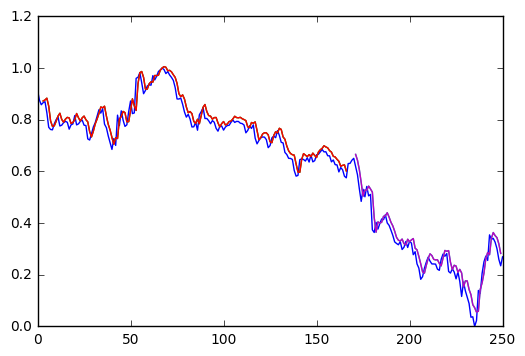

In [82]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(norm_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(norm_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(norm_dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.fit_transform(df['Open']))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
